In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms

import mediapipe as mp

from metric import oks_metric, oks_over_dataset
from dataset import DatasetKeypoints

from modeling._mano import MANO, Mesh

# 1. Data

[Dataset link](http://domedb.perception.cs.cmu.edu/handdb.html)

Пусть структура нашей выборки будет представлять из себя кортеж с изображением и набором ключевых точек обеих рук, сначала левой, затем правой.

In [2]:
test_ds_path = './data/hand_labels/manual_test'
test_ds = DatasetKeypoints(test_ds_path, img_size=224)

  0%|          | 0/846 [00:00<?, ?it/s]

torch.Size([3, 224, 224])
torch.Size([42, 3])


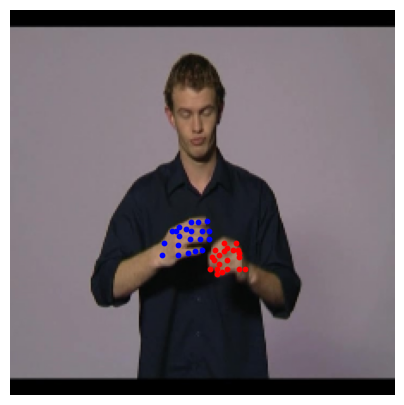

In [3]:
tens_img, tens_lbl = test_ds[1]

print(tens_img.shape)
print(tens_lbl.shape)


fig, ax = plt.subplots(figsize=(5, 5))

dots = tens_lbl.numpy()[:, :-1].astype(int)
plt.imshow(tens_img.numpy().transpose(1, 2, 0))
plt.scatter(dots[:, 0][:21], dots[:, 1][:21], s=10, c='r')
plt.scatter(dots[:, 0][21:], dots[:, 1][21:], s=10, c='b')

plt.axis('off')
plt.show()

# 2. Mediapipe Model

In [4]:
class MediapipeModel:
    def __init__(self, img_size):
        self.img_size = img_size
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(
            static_image_mode=True,
            max_num_hands=2
        )

    def _collect_keypoints(self, res):
        if res is not None:
            hands = res.multi_hand_landmarks
            if hands is not None:
                # left_hand:
                if len(hands) > 1:
                    left_h = [
                        [finger.x, finger.y]
                        for finger in hands[1].landmark
                    ]
                else:
                    left_h = [[0, 0]] * 21
                # right hand:
                if len(hands) > 0:
                    right_h = [
                        [finger.x, finger.y]
                        for finger in hands[0].landmark
                    ]
                else:
                    right_h = [[0, 0]] * 21
                # all hands keypoints:
                keypoints = np.vstack([
                    left_h, right_h
                ]) * self.img_size
                return keypoints.astype(int)
            else:
                return np.array([[0, 0]] * 42)
        else:
            return np.array([[0, 0]] * 42)
        
    def __call__(self, img: np.array):
        res = self.hands.process(img)
        kps = self._collect_keypoints(res)
        return kps

In [5]:
mediapipe_model = MediapipeModel(img_size=224)

In [6]:
array_img = (
    tens_img.numpy().transpose(1, 2, 0) * 255
).astype('uint8')

In [7]:
st_kps = mediapipe_model(array_img)
st_kps.shape

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(42, 2)

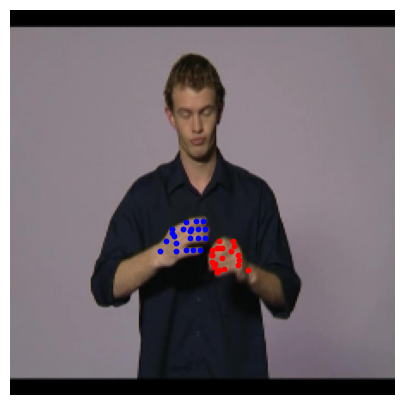

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.imshow(tens_img.numpy().transpose(1, 2, 0))
plt.scatter(st_kps[:, 0][:21], st_kps[:, 1][:21], s=10, c='r')
plt.scatter(st_kps[:, 0][21:], st_kps[:, 1][21:], s=10, c='b')

plt.axis('off')
plt.show()

# 3. Metric

In [9]:
print(dots.shape)
print(st_kps.shape)

(42, 2)
(42, 2)


In [10]:
oks_metric(dots, st_kps)

0.3455907853618101

In [11]:
oks_over_dataset(test_ds, mediapipe_model)

  0%|          | 0/846 [00:00<?, ?it/s]

0.15454130372856664

# 4. Our model

In [60]:
class HandTopDownRecognition:
    
    def __init__(self, device = "cuda",checkpoint = 'weights/model.bin'):
        self.mano = MANO().to(device)
        self.mano.layer = self.mano.layer.cuda()
        self.mesh_sampler = Mesh()
        self.prepare_augmentation()
        self.create_model(checkpoint, device)
    
    def prepare_augmentation(self):
        self.transform = transforms.Compose([           
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])

        self.transform_visualize = transforms.Compose([           
                            transforms.Resize(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor()])
    
    def create_model(self, checkpoint, device):
        self._model = torch.load(checkpoint)
        setattr(self._model.trans_encoder[-1].config,'output_attentions', True)
        setattr(self._model.trans_encoder[-1].config,'output_hidden_states', True)
        self._model.trans_encoder[-1].bert.encoder.output_attentions = True
        self._model.trans_encoder[-1].bert.encoder.output_hidden_states =  True
        for iter_layer in range(4):
            self._model.trans_encoder[-1].bert.encoder.layer[iter_layer].attention.self.output_attentions = True
        for inter_block in range(3):
            setattr(self._model.trans_encoder[-1].config,'device', device)
        self._model.to(device)
        
    def run_inference(self, img):
        self._model.eval()
        self.mano.eval()
        with torch.no_grad():
            img_tensor = self.transform(img)
            img_visual = self.transform_visualize(img)
            batch_imgs = torch.unsqueeze(img_tensor, 0).cuda()
            batch_visual_imgs = torch.unsqueeze(img_visual, 0).cuda()
            pred_camera, pred_3d_joints, pred_vertices_sub, pred_vertices, hidden_states, att = self._model(batch_imgs, self.mano, self.mesh_sampler) 
        return pred_3d_joints, pred_camera
    
    def orthographic_projection(self,X, camera):
        camera = camera.view(-1, 1, 3)
        X_trans = X[:, :, :2] + camera[:, :, 1:]
        shape = X_trans.shape
        X_2d = (camera[:, :, 0] * X_trans.view(shape[0], -1)).view(shape)
        return X_2d
    
    def get_keypoints(self, img):
        points_3d, camera = self.run_inference(img)
        points_2d = self.orthographic_projection(points_3d.contiguous(), camera.contiguous())
        return points_2d
    
    
class MediapipeHandDetector:
    def __init__(self):
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(
            static_image_mode=True,
            max_num_hands=1
        )
    
    def make_square(self, box):
        const = 3.078343710504076
        box = box
        cf = int(np.linalg.norm(np.array(box[2:])-np.array(box[:2])) / const)
        x_dist = box[3] - box[1]
        y_dist = box[2] - box[0]
        if x_dist >  y_dist:
            razn = x_dist - y_dist
            box[2] += razn
        elif y_dist >  x_dist:
            razn = y_dist - x_dist
            box[3] += razn
        box[0], box[1], box[2], box[3] =  box[0] - cf, box[1] - cf, box[2] + cf, box[3] + cf
        return box

    def convert_to_bbox(self, box):
        box = np.array(box)
        x_min = np.min(box[:,0]) - 40
        x_max = np.max(box[:,0]) + 40
        y_min = np.min(box[:,1]) - 40
        y_max = np.max(box[:,1]) + 40
        return [x_min,y_min,x_max,y_max]

    def __call__(self, img):
        h, w, _ = img.shape
        results = self.hands.process(img)
        prebox = []
        if results.multi_hand_landmarks is not None:
            for hand_landmarks in results.multi_hand_landmarks:
                hand = []
                for finger_tip in hand_landmarks.landmark:
                    hand.append([int(finger_tip.x * w), int(finger_tip.y * h)])
                prebox.append(self.make_square(self.convert_to_bbox(hand)))
        return prebox
    
    
class SelfMadeModel:
    def __init__(self, hand_detector, keypoints_detector):
        self.hand_detector = hand_detector
        self.keypoints_detector = keypoints_detector
        
    def _get_keypoints(self, img: np.array, points) -> np.array:
        pil_img = Image.fromarray(img)
        pil_img_size = pil_img.size
        crop = pil_img.crop(points)
        keypoints = hand.get_keypoints(crop)
        keypoints = (keypoints + 1) * 0.5
        keypoints[:,:,0] = (keypoints[:,:,0] * crop.size[0]) + points[0]
        keypoints[:,:,1] = (keypoints[:,:,1] * crop.size[1]) + points[1]
        keypoints = keypoints.cpu().detach().squeeze().numpy().astype(int)
        return keypoints
        
    def __call__(self, img: np.array):
        boxes = detector(img)
        lb = len(boxes)
        result = np.array([]).reshape(0, 2)
        if lb > 0:
            # left hand:
            keypoints_l = self._get_keypoints(img, boxes[0])
            result = np.vstack([result, keypoints_l])
            # right hand:
            if lb > 1:
                keypoints_r = self._get_keypoints(img, boxes[1])
                result = np.vstack([result, keypoints_r])
            else:
                result = np.vstack([result, [[0, 0]] * 21])
            return result
        else:
            return np.array([[0, 0]] * 42)

In [61]:
detector = MediapipeHandDetector()
hand = HandTopDownRecognition()

our_model = SelfMadeModel(detector, hand)

/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/skibinmv/anaconda3/envs/gphmr/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/hom

In [64]:
our_st_kps = our_model(array_img)

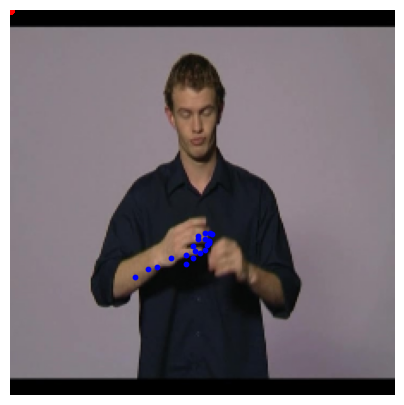

In [65]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.imshow(tens_img.numpy().transpose(1, 2, 0))
plt.scatter(our_st_kps[:, 0][21:], our_st_kps[:, 1][21:], s=10, c='r')
plt.scatter(our_st_kps[:, 0][:21], our_st_kps[:, 1][:21], s=10, c='b')

plt.axis('off')
plt.show()

In [66]:
oks_over_dataset(test_ds, our_model)

  0%|          | 0/846 [00:00<?, ?it/s]

0.0028238024974251157

# 5. Summary

|Model|OKS|
|:----|:--|
|Mediapipe Hand Key Points Detector|0.155|
|Self Made Detector|0.00282|